<a href="https://colab.research.google.com/github/Rustam-ksnv/T01/blob/main/%D0%94%D0%97_%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [268]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [269]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [270]:
# Нестационарный ряд
series_1 = pd.read_csv("international-airline-passengers.csv")['Count']
# Стационарный ряд
series_2 = boxcox(series_1, 0)
series_2 = series_2[1:] - series_2[:-1]
series_2 = series_2[12:] - series_2[:-12]

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


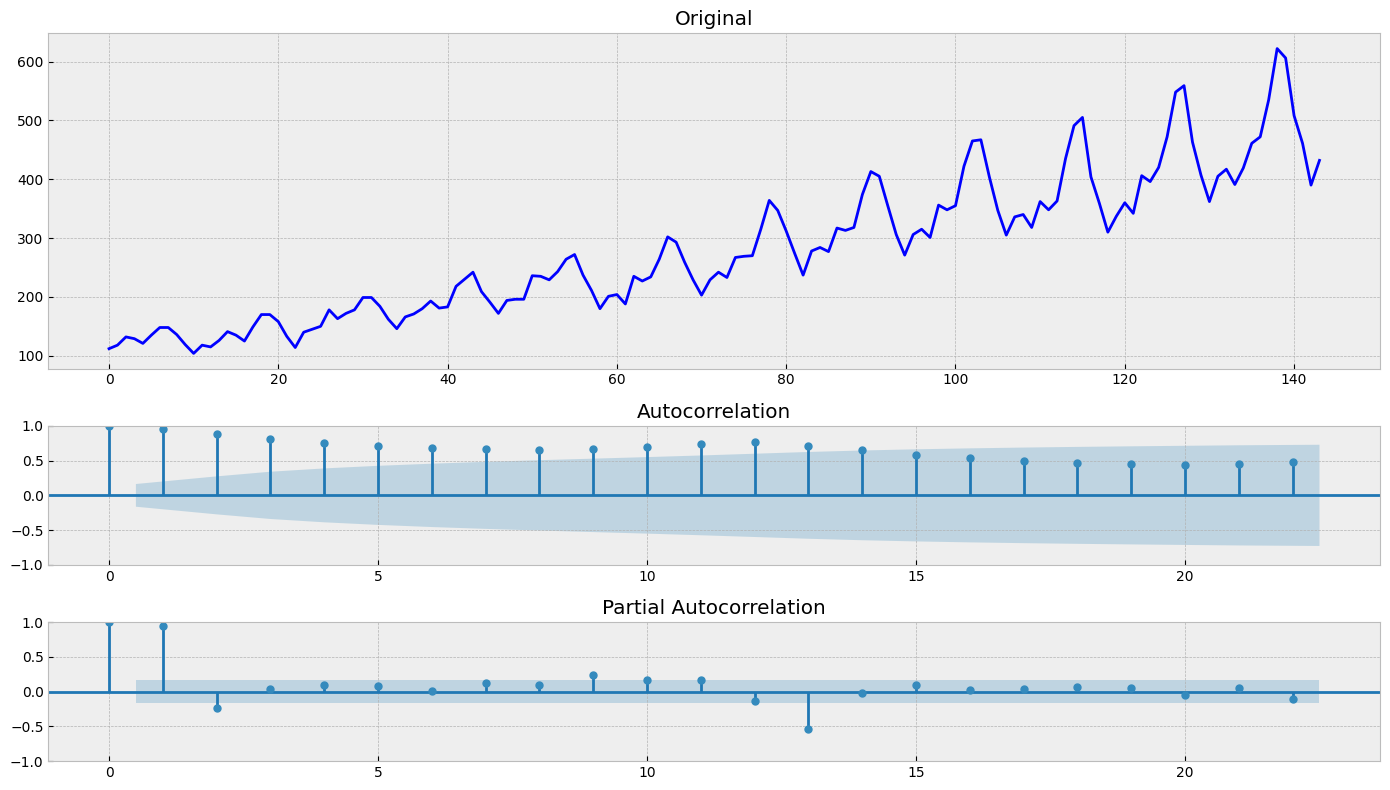

In [271]:
# Нестационарный ряд
tsplot(series_1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


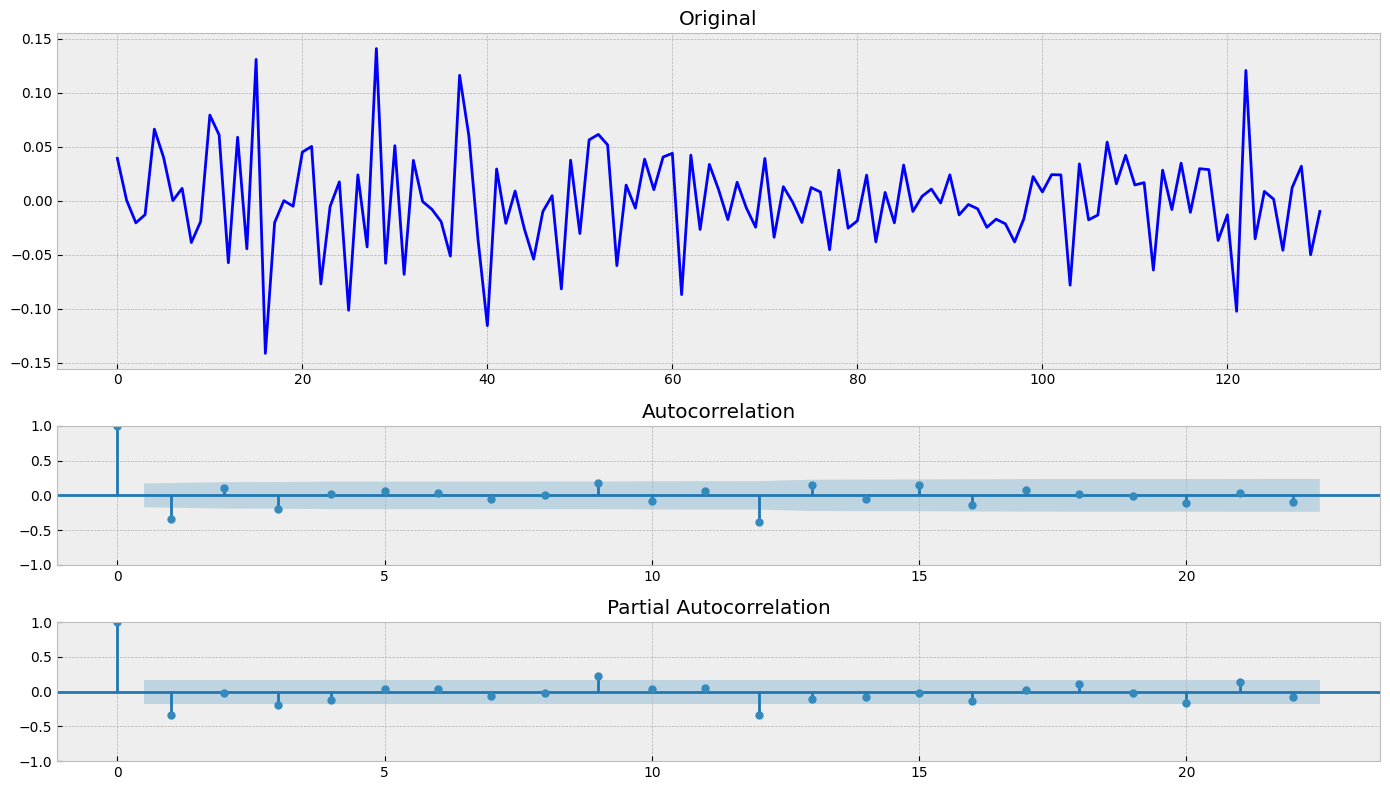

In [272]:
# Стационарный ряд
tsplot(series_2)

In [273]:
# Нестационарный ряд

# Применим метод Хольта-Винтерса

def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
      sum += float(series[i + season_len] - series[i]) / season_len
    # return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len
    return sum / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [274]:
alpha = 0.325
beta = 0.125
gamma = 0.1
n_preds = 12

In [275]:
# Прогноз
Series_HV_1 = triple_exponential_smoothing(series_1, 12, alpha, beta, gamma, n_preds)

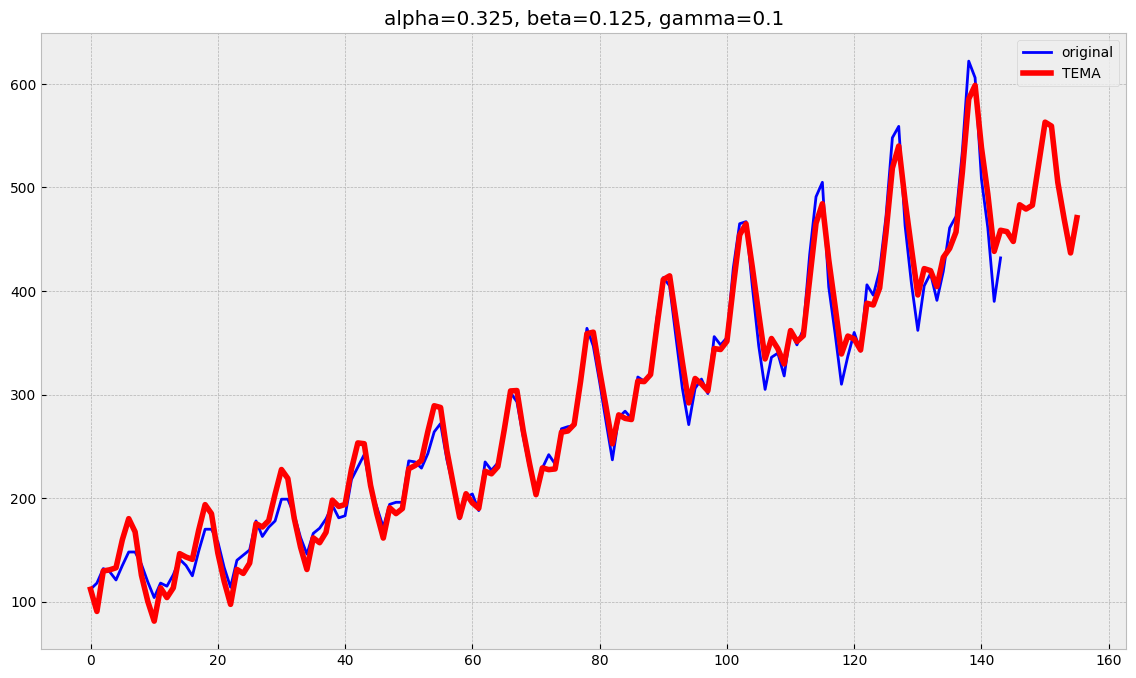

In [276]:
plot_tema(alpha, beta, gamma, series_1, series_1, n_preds)

In [277]:
# приведем к стационарному ряду прогноз
Series_HV_1_st = boxcox(Series_HV_1, 0)
Series_HV_1_st = Series_HV_1_st[1:] - Series_HV_1_st[:-1]
Series_HV_1_st = Series_HV_1_st[12:] - Series_HV_1_st[:-12]

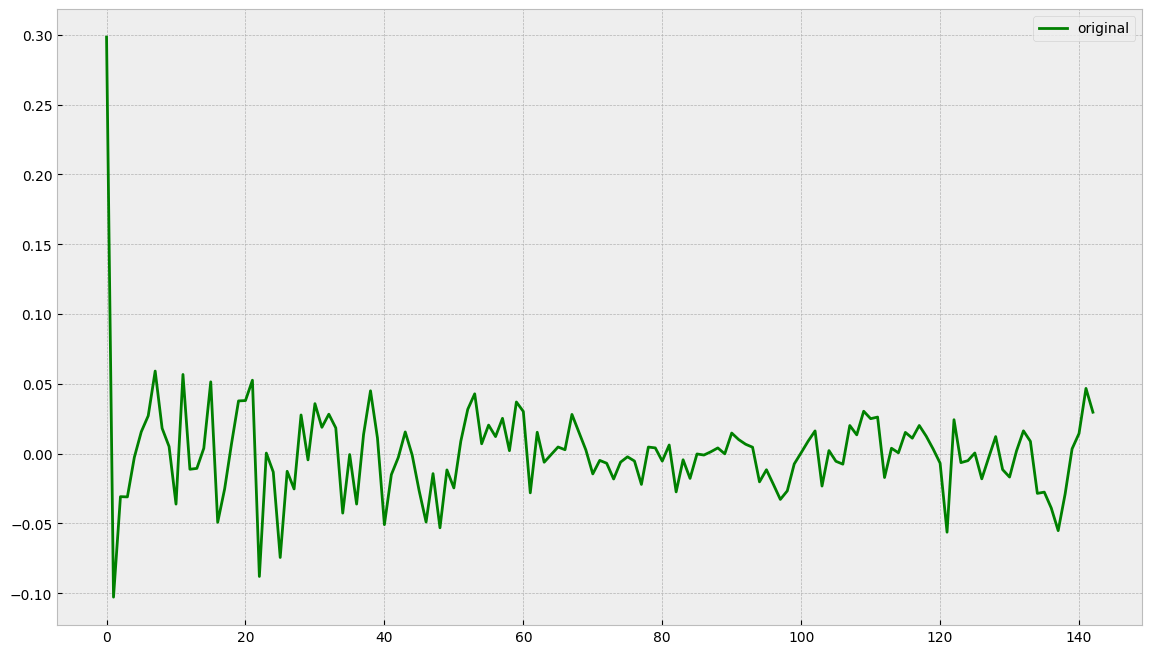

In [278]:
# Построим график стационарного прогноза
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(Series_HV_1_st, color='green',label='original')
        plt.legend()

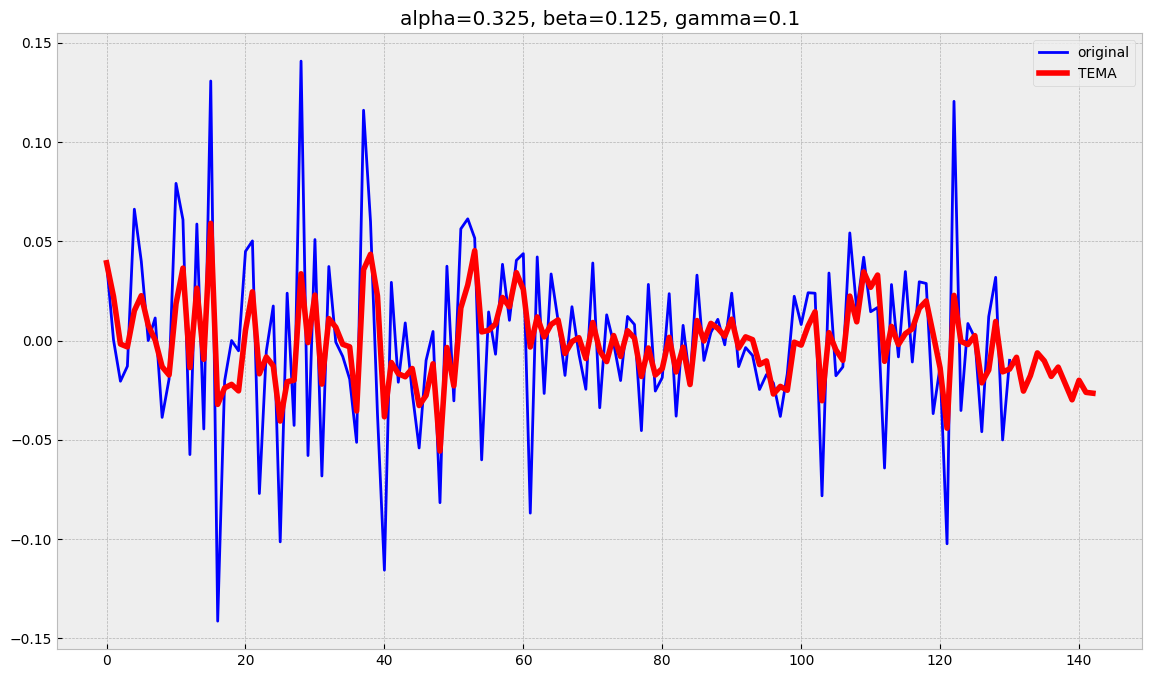

In [279]:
# Стационарный ряд
# Применим метод Хольта-Винтерса
# Построим прогноз
Series_HV_2 = triple_exponential_smoothing(series_2, 12, alpha, beta, gamma, n_preds)
plot_tema(alpha, beta, gamma, series_2, series_2, n_preds)

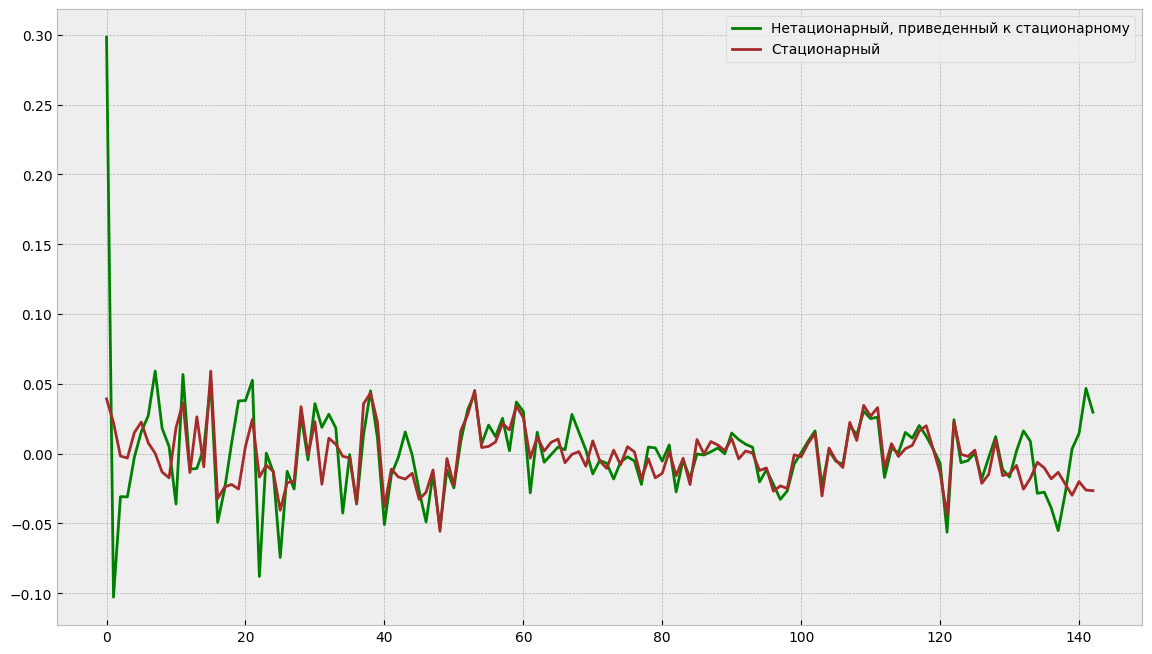

In [280]:
# Объединим два прогноза (Прогноз нестационарного ряда, приведенного к стационарному и прогноз стационарного ряда) на одном графике.
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(Series_HV_1_st, color='green',label='Нетационарный, приведенный к стационарному')
        plt.plot(Series_HV_2, color='brown',label='Стационарный')
        plt.legend()

In [281]:
# вывод:
# - для нестационарного рядая выбран мето сглаживания Хольта-Винтерса, так как он учитывает временной контекст, берёт в расчёт трендовую и сезонную составляющие. И как показывает график (TEMA-original) - дает вполне вменяемый прогноз на 12 значений вперед.
# - применение же данного метода к стационарному ряду, мене информативено, и в части прогноза дает более сглаженную кривую, по сравнению с аналогичной кривой, полученной путем преобразования нестационарного прогноза к стационарному ряду.